## Using in Google Colabs

In [ ]:
'''! pip install kaggle
from google.colab import drive
drive.mount('/content/drive')
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/Kaggle\ API/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json'''

## Using Kaggle Imports 

In [ ]:
'''import kaggle
import kagglehub

# Download latest version
path = "/kaggle/input/cotton-leaf-disease-dataset/cotton"

print("Path to dataset files:", path)'''

# Cotton Leaf Disease Classification

### 1.0 Imports

In [2]:
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [ ]:
path = "/kaggle/input/cotton-leaf-disease-dataset/cotton"

### 2. Load Data

In [5]:
transform = transforms.Compose([
    transforms.Resize(384),
    transforms.CenterCrop(350),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(path, transform=transform)

train_size = len(dataset) // 2
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # No shuffle for testing

labels_map = {
    0: "bacterial_blight",
    1: "curl_virus",
    2: "fussarium_wilt",
    3: "healthy",
}

image, label = train_dataset[0]
image.size()

torch.Size([3, 350, 350])

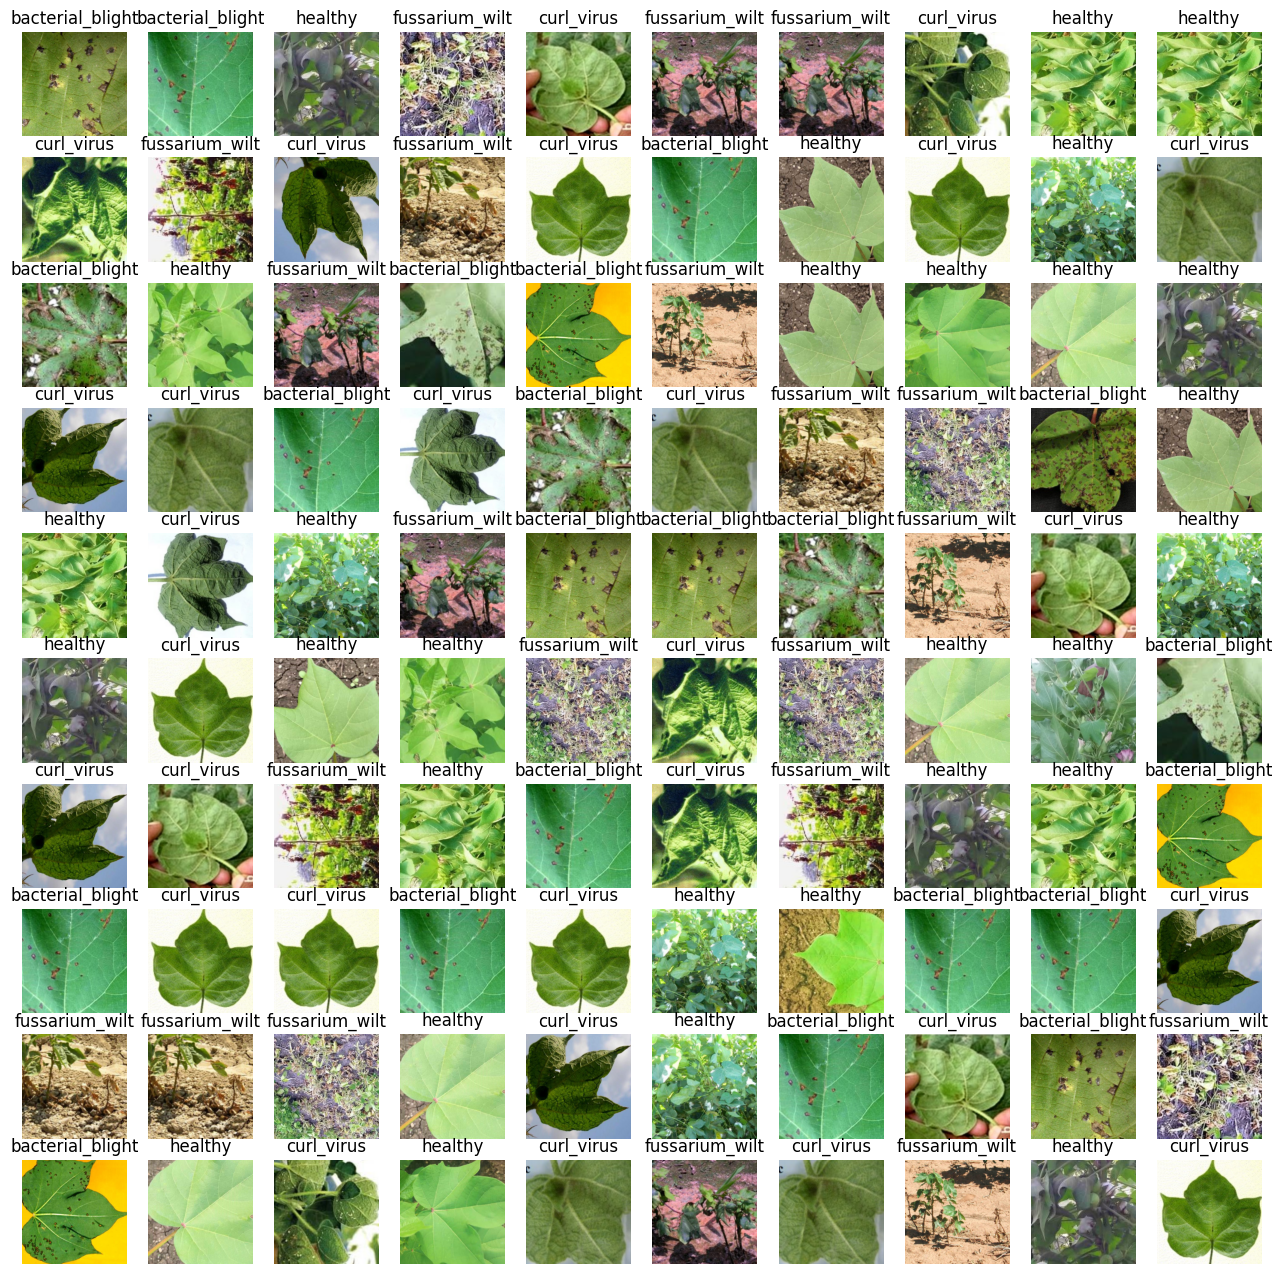

In [5]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Display Sample Images
figure = plt.figure(figsize=(16, 16))
cols, rows = 10, 10

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(images), size=(1,)).item()
    img, label = images[sample_idx], labels[sample_idx].item()

    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")

    img = img.permute(1, 2, 0)  # Convert (C, H, W) to (H, W, C) for display
    plt.imshow(img)

plt.show()


### 3. Object Detection Leaf/Plant

In [ ]:
# Nats Code



## 4. Image Classification

### 4.1 Base Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class NeuralNetwork (nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, 7) #(32, 344, 344)
        self.pool = nn.MaxPool2d (2, 2) #(32, 172, 172)
        self.conv2 = nn.Conv2d(32, 64, 7) #(64, 166, 166) #(64, 83, 83)
        self.conv3 = nn.Conv2d (64, 128, 7) # Output: (256, 76, 76) #(128, 38, 38)
        self.conv4 = nn.Conv2d(128, 256, 7) #(256, 32, 32) #(256, 16, 16)

        self.fc1 = nn.Linear(256 * 16 * 16, 8192)
        self.fc2 = nn.Linear(8192, 1024)
        self.fc3 = nn.Linear(1024, 128)
        self.fc4 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x

In [ ]:
training_net = NeuralNetwork()

loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(training_net.parameters(), lr=0.001)

In [ ]:
import torch
from tqdm import tqdm

num_epochs = 50

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
training_net.to(device)

for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)

    running_loss = 0.0
    for i, data in loop:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = training_net(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item())

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {running_loss/len(train_loader):.6f}")

loop.close()


In [ ]:
torch.save(training_net.state_dict(), 'trained_net.pth')

In [ ]:
test_net = NeuralNetwork()

test_net.load_state_dict(torch.load('trained_net.pth'))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_net.to(device)

test_net.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)

        outputs = test_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)

        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the network on the test images: {accuracy:.2f}%')


### 4.2 VGG16 Model

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class VGG16(nn.Module):
    def __init__(self, num_classes=4):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(10*10*512, 4096),  # Adjusted from 7*7*512 to 10*10*512
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [7]:
num_classes = 4
num_epochs = 100
batch_size = 32
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VGG16(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

In [8]:
total_step = len(train_loader)
# training loop
for epoch in range(num_epochs):
    train_loop = tqdm(enumerate(train_loader), total=total_step, desc=f'Epoch {epoch+1}/{num_epochs}')
    for i, (images, labels) in train_loop:  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update tqdm loop display
        train_loop.set_postfix(loss=loss.item())

    # Validation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        validation_loop = tqdm(test_loader, desc='Validating')
        for images, labels in validation_loop:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
    
    accuracy = 100 * correct / total
    print('Accuracy of the network on the {} validation images: {:.2f} %'.format(total, accuracy))
    model.train()


Validating: 100%|██████████| 27/27 [00:17<00:00,  1.53it/s]


Accuracy of the network on the 855 validation images: 24.21 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.10it/s]


Accuracy of the network on the 855 validation images: 55.32 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.10it/s]


Accuracy of the network on the 855 validation images: 78.13 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.08it/s]


Accuracy of the network on the 855 validation images: 84.68 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.09it/s]


Accuracy of the network on the 855 validation images: 71.11 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.08it/s]


Accuracy of the network on the 855 validation images: 90.29 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.12it/s]


Accuracy of the network on the 855 validation images: 86.08 %


Validating: 100%|██████████| 27/27 [00:13<00:00,  2.07it/s]


Accuracy of the network on the 855 validation images: 82.57 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.09it/s]


Accuracy of the network on the 855 validation images: 89.24 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.10it/s]


Accuracy of the network on the 855 validation images: 90.99 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.11it/s]


Accuracy of the network on the 855 validation images: 91.35 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.08it/s]


Accuracy of the network on the 855 validation images: 89.24 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.08it/s]


Accuracy of the network on the 855 validation images: 87.25 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.10it/s]


Accuracy of the network on the 855 validation images: 92.16 %


Validating: 100%|██████████| 27/27 [00:13<00:00,  2.07it/s]


Accuracy of the network on the 855 validation images: 92.63 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.08it/s]


Accuracy of the network on the 855 validation images: 93.45 %


Validating: 100%|██████████| 27/27 [00:13<00:00,  2.05it/s]


Accuracy of the network on the 855 validation images: 95.32 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.09it/s]


Accuracy of the network on the 855 validation images: 96.26 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.11it/s]


Accuracy of the network on the 855 validation images: 96.26 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.08it/s]


Accuracy of the network on the 855 validation images: 92.51 %


Validating: 100%|██████████| 27/27 [00:13<00:00,  2.05it/s]


Accuracy of the network on the 855 validation images: 95.44 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.10it/s]


Accuracy of the network on the 855 validation images: 97.08 %


Validating: 100%|██████████| 27/27 [00:13<00:00,  2.07it/s]


Accuracy of the network on the 855 validation images: 96.61 %


Validating: 100%|██████████| 27/27 [00:13<00:00,  2.05it/s]


Accuracy of the network on the 855 validation images: 96.84 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.10it/s]


Accuracy of the network on the 855 validation images: 97.54 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.08it/s]


Accuracy of the network on the 855 validation images: 93.22 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.10it/s]


Accuracy of the network on the 855 validation images: 95.56 %


Validating: 100%|██████████| 27/27 [00:13<00:00,  2.08it/s]


Accuracy of the network on the 855 validation images: 93.80 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.10it/s]


Accuracy of the network on the 855 validation images: 95.09 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.09it/s]


Accuracy of the network on the 855 validation images: 96.73 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.11it/s]


Accuracy of the network on the 855 validation images: 97.19 %


Validating: 100%|██████████| 27/27 [00:13<00:00,  2.07it/s]


Accuracy of the network on the 855 validation images: 96.73 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.12it/s]


Accuracy of the network on the 855 validation images: 96.96 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.12it/s]


Accuracy of the network on the 855 validation images: 96.96 %


Validating: 100%|██████████| 27/27 [00:13<00:00,  2.07it/s]


Accuracy of the network on the 855 validation images: 97.19 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.09it/s]


Accuracy of the network on the 855 validation images: 97.66 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.10it/s]


Accuracy of the network on the 855 validation images: 97.19 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.08it/s]


Accuracy of the network on the 855 validation images: 96.73 %


Validating: 100%|██████████| 27/27 [00:13<00:00,  2.05it/s]


Accuracy of the network on the 855 validation images: 96.84 %


Validating: 100%|██████████| 27/27 [00:13<00:00,  2.07it/s]


Accuracy of the network on the 855 validation images: 97.19 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.09it/s]


Accuracy of the network on the 855 validation images: 96.14 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.12it/s]


Accuracy of the network on the 855 validation images: 96.73 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.11it/s]


Accuracy of the network on the 855 validation images: 97.54 %


Validating: 100%|██████████| 27/27 [00:13<00:00,  2.07it/s]


Accuracy of the network on the 855 validation images: 96.73 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.14it/s]


Accuracy of the network on the 855 validation images: 95.56 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.11it/s]


Accuracy of the network on the 855 validation images: 97.08 %


Validating: 100%|██████████| 27/27 [00:13<00:00,  2.04it/s]


Accuracy of the network on the 855 validation images: 97.31 %


Validating: 100%|██████████| 27/27 [00:13<00:00,  2.07it/s]


Accuracy of the network on the 855 validation images: 97.31 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.11it/s]


Accuracy of the network on the 855 validation images: 97.54 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.09it/s]


Accuracy of the network on the 855 validation images: 97.19 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.10it/s]


Accuracy of the network on the 855 validation images: 95.56 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.08it/s]


Accuracy of the network on the 855 validation images: 95.79 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.11it/s]


Accuracy of the network on the 855 validation images: 96.84 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.10it/s]


Accuracy of the network on the 855 validation images: 97.54 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.10it/s]


Accuracy of the network on the 855 validation images: 97.66 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.09it/s]


Accuracy of the network on the 855 validation images: 97.19 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.08it/s]


Accuracy of the network on the 855 validation images: 96.84 %


Validating: 100%|██████████| 27/27 [00:13<00:00,  2.05it/s]


Accuracy of the network on the 855 validation images: 90.99 %


Validating: 100%|██████████| 27/27 [00:13<00:00,  2.06it/s]


Accuracy of the network on the 855 validation images: 96.73 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.10it/s]


Accuracy of the network on the 855 validation images: 96.96 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.11it/s]


Accuracy of the network on the 855 validation images: 96.49 %


Validating: 100%|██████████| 27/27 [00:13<00:00,  2.06it/s]


Accuracy of the network on the 855 validation images: 94.85 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.09it/s]


Accuracy of the network on the 855 validation images: 94.97 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.13it/s]


Accuracy of the network on the 855 validation images: 94.04 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.10it/s]


Accuracy of the network on the 855 validation images: 93.68 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.11it/s]


Accuracy of the network on the 855 validation images: 94.74 %


Validating: 100%|██████████| 27/27 [00:13<00:00,  2.07it/s]


Accuracy of the network on the 855 validation images: 93.10 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.08it/s]


Accuracy of the network on the 855 validation images: 92.63 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.10it/s]


Accuracy of the network on the 855 validation images: 92.28 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.08it/s]


Accuracy of the network on the 855 validation images: 93.33 %


Validating: 100%|██████████| 27/27 [00:13<00:00,  2.06it/s]


Accuracy of the network on the 855 validation images: 96.02 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.13it/s]


Accuracy of the network on the 855 validation images: 96.14 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.10it/s]


Accuracy of the network on the 855 validation images: 96.02 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.09it/s]


Accuracy of the network on the 855 validation images: 92.98 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.11it/s]


Accuracy of the network on the 855 validation images: 96.26 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.09it/s]


Accuracy of the network on the 855 validation images: 96.14 %


Validating: 100%|██████████| 27/27 [00:13<00:00,  2.07it/s]


Accuracy of the network on the 855 validation images: 96.14 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.09it/s]


Accuracy of the network on the 855 validation images: 96.37 %


Validating: 100%|██████████| 27/27 [00:13<00:00,  2.06it/s]


Accuracy of the network on the 855 validation images: 96.14 %


Validating: 100%|██████████| 27/27 [00:13<00:00,  2.07it/s]


Accuracy of the network on the 855 validation images: 96.37 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.11it/s]


Accuracy of the network on the 855 validation images: 96.61 %


Validating: 100%|██████████| 27/27 [00:13<00:00,  2.07it/s]


Accuracy of the network on the 855 validation images: 96.61 %


Validating: 100%|██████████| 27/27 [00:13<00:00,  2.07it/s]


Accuracy of the network on the 855 validation images: 96.84 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.12it/s]


Accuracy of the network on the 855 validation images: 96.96 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.09it/s]


Accuracy of the network on the 855 validation images: 97.19 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.09it/s]


Accuracy of the network on the 855 validation images: 97.08 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.12it/s]


Accuracy of the network on the 855 validation images: 96.73 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.11it/s]


Accuracy of the network on the 855 validation images: 95.56 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.09it/s]


Accuracy of the network on the 855 validation images: 94.62 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.11it/s]


Accuracy of the network on the 855 validation images: 96.37 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.10it/s]


Accuracy of the network on the 855 validation images: 97.08 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.09it/s]


Accuracy of the network on the 855 validation images: 96.61 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.10it/s]


Accuracy of the network on the 855 validation images: 95.91 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.08it/s]


Accuracy of the network on the 855 validation images: 97.08 %


Validating: 100%|██████████| 27/27 [00:13<00:00,  2.07it/s]


Accuracy of the network on the 855 validation images: 96.26 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.11it/s]


Accuracy of the network on the 855 validation images: 96.73 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.11it/s]


Accuracy of the network on the 855 validation images: 97.08 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.08it/s]


Accuracy of the network on the 855 validation images: 96.49 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.12it/s]


Accuracy of the network on the 855 validation images: 96.37 %


Validating: 100%|██████████| 27/27 [00:12<00:00,  2.08it/s]

Accuracy of the network on the 855 validation images: 95.67 %


In [11]:
torch.save(model.state_dict(), 'vgg16_model.pth')

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VGG16(num_classes).to(device)

model.load_state_dict(torch.load('vgg16_model.pth', map_location=device, weights_only=True))
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))   

100%|██████████| 27/27 [00:12<00:00,  2.10it/s]

Accuracy of the network on the test images: 96.14035087719299 %
